Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,800))

Plots.GRBackend()

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = @__DIR__
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(joinpath(dirname(Base.pathof(StatisticalRethinking)), "..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


Define the Stan language model

In [5]:
heightsmodel = "
// Inferring a Rate
data {
  int N;
  real<lower=0> h[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0,upper=250> mu;
}
model {
  // Priors for mu and sigma
  mu ~ uniform(100, 250);
  sigma ~ cauchy( 0 , 1 );

  // Observed heights
  h ~ normal(mu, sigma);
}
"

"\n// Inferring a Rate\ndata {\n  int N;\n  real<lower=0> h[N];\n}\nparameters {\n  real<lower=0> sigma;\n  real<lower=0,upper=250> mu;\n}\nmodel {\n  // Priors for mu and sigma\n  mu ~ uniform(100, 250);\n  sigma ~ cauchy( 0 , 1 );\n\n  // Observed heights\n  h ~ normal(mu, sigma);\n}\n"

Define the Stanmodel and set the output format to :mcmcchain.

In [6]:
stanmodel = Stanmodel(name="heights", monitors = ["mu", "sigma"],model=heightsmodel,
  output_format=:mcmcchain)
# Input data for cmdstan
heightsdata = [
  Dict("N" => length(df2[:height]), "h" => df2[:height])
]

=====> /Users/rob/.julia/dev/StatisticalRethinking/notebooks/04



1-element Array{Dict{String,Any},1}:
 Dict("N"=>352,"h"=>Union{Missing, Float64}[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75])

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME)
# Describe the draws
describe(chn)


make: `/Users/rob/.julia/dev/StatisticalRethinking/notebooks/04/tmp/heights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in '/Users/rob/.julia/dev/StatisticalRethinking/notebooks/04/tmp/heights.stan' at line 16)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Calling /Users/rob/Projects/StanSupport/cmdstan/bin/stansummary to infer across chains.

Inference for Stan model: heights_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.033, 0.034, 0.034, 0.035) seconds, 0.14 seconds total

Compare with previous result

In [8]:
clip_07s_example_output = "

Samples were drawn using hmc with nuts.
For each parameter, N_Eff is a crude measure of effective sample size,
and R_hat is the potential scale reduction factor on split chains (at
convergence, R_hat=1).

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
          Mean        SD      Naive SE      MCSE      ESS
sigma   7.7641718 0.3055115 0.004830561 0.0047596714 1000
   mu 154.6042417 0.4158242 0.006574758 0.0068304868 1000

Quantiles:
         2.5%       25.0%       50.0%      75.0%      97.5%
sigma   7.198721   7.5573575   7.749435   7.960795   8.393317
   mu 153.795975 154.3307500 154.610000 154.884000 155.391050

"

"\n\nSamples were drawn using hmc with nuts.\nFor each parameter, N_Eff is a crude measure of effective sample size,\nand R_hat is the potential scale reduction factor on split chains (at\nconvergence, R_hat=1).\n\nIterations = 1:1000\nThinning interval = 1\nChains = 1,2,3,4\nSamples per chain = 1000\n\nEmpirical Posterior Estimates:\n          Mean        SD      Naive SE      MCSE      ESS\nsigma   7.7641718 0.3055115 0.004830561 0.0047596714 1000\n   mu 154.6042417 0.4158242 0.006574758 0.0068304868 1000\n\nQuantiles:\n         2.5%       25.0%       50.0%      75.0%      97.5%\nsigma   7.198721   7.5573575   7.749435   7.960795   8.393317\n   mu 153.795975 154.3307500 154.610000 154.884000 155.391050\n\n"

Plot the density of posterior draws

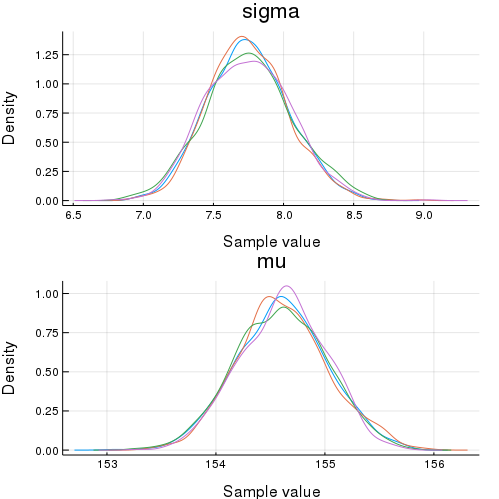

In [9]:
density(chn)

Close cd(ProjDir) do block

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*